# **Regression (Excluding Text Features)**

-------
### Imports

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, precision_score, silhouette_score

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


-------
## Reading in the Listings Dataset

In [2]:
listings = pd.read_csv('../data/listings_cleaned.csv')

In [3]:
listings.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,state,bathrooms,bathrooms_shared,amenities_count,host_verifications_count,private_listing
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0,0,0.29,Boston,Massachusetts,1.0,0,31,3,1
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0,0,0.90,Boston,Massachusetts,1.0,0,30,4,1


------
# **Modeling**

In [4]:
# building a simple model to gauge performance
features = ['amenities_count', 'host_response_time', 
            'host_response_rate', 'host_has_profile_pic','accommodates','license',
            'reviews_per_month', 'host_verifications_count'] # intentionally not including price, didn't appear to be strong predictor of rating based on EDA

# define X and y
X = listings[features]
y = listings['rating']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape)
print(X_test.shape)

(7998, 8)
(2666, 8)


## Scale and fit Basic KNN

In [ ]:
ss= StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
# instantiate and fit KNNeighbors model with defaults
knn = KNeighborsRegressor()
knn.fit(X_train_sc, y_train)

print(f'training accuracy: {knn.score(X_train_sc, y_train)}')
print(f'test accuracy: {knn.score(X_test_sc, y_test)}')

training accuracy: 0.43748293304323993
test accuracy: 0.07033625389525022


## Fit Linear Regression

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print(f'training accuracy: {lr.score(X_train, y_train)}')
print(f'test accuracy: {lr.score(X_test, y_test)}')

training accuracy: 0.04155438594963001
test accuracy: 0.024237697516732215


In [16]:
# see if standardizing improves performance
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

print(f'training accuracy: {lr.score(X_train_sc, y_train)}')
print(f'test accuracy: {lr.score(X_test_sc, y_test)}')

training accuracy: 0.04155438594963001
test accuracy: 0.024237697516732215


Poor performance on the basic features selected. KNN performed best in this scenario, though it's significantly overfit.

-------

## Attempt to throw more features at the models

In [17]:
# preprocessing to make sure desired feature columns are numerical

# dummify neighborhood, property type, and room type columns
print(listings.shape)
listings_dummy = pd.get_dummies(listings, columns = ['neighborhood','property_type','room_type'], drop_first = True)


listings_dummy.shape

(10664, 53)


(10664, 123)

In [18]:
features = [col for col in listings_dummy._get_numeric_data().columns if col != 'rating_target' and col != 'rating']
features

['id',
 'host_id',
 'host_response_time',
 'host_response_rate',
 'host_is_superhost',
 'abnb_host_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'accommodates',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'available_today',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'license',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month',
 'bathrooms',
 'bathrooms_shared',
 'amenities_count',
 'host_verifications_count',
 'private_listing',
 'neighborhood_Back Bay',
 'neighborhood_Bay Village',
 'neighborhood_Beacon Hill',
 'neighborhood_Brighton',
 'neighborhood_Charlestown',
 'neighborhood_Chinatow

In [19]:
# define X and y
X = listings_dummy[features]
y = listings_dummy['rating']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
print(X_train.shape)
print(X_test.shape)

(7998, 110)
(2666, 110)


## Fit Linear Regression

In [89]:
# see if standardizing improves performance
# avoid KNN this time as it doesn't typically do well with high dimensionality
lr = LinearRegression()
lr.fit(X_train_sc, y_train)

print(f'training accuracy: {lr.score(X_train_sc, y_train)}')
print(f'test accuracy: {lr.score(X_test_sc, y_test)}')

training accuracy: 0.1152320782332733
test accuracy: -1.0491998488384041e+25


------
## Random Forest

In [28]:
# Try Random Forest
features = [col for col in listings_dummy._get_numeric_data().columns if col != 'rating_target' and col != 'rating']
print(len(features))

# define X and y
X = listings_dummy[features]
y = listings_dummy['rating']

# stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

110


RandomForestRegressor()

In [29]:
# evaluating performance
print(cross_val_score(rf, X_train, y_train, cv = 5).mean())
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.5147209801571296
0.9411982642132287
0.5653586176492986


# Boosted Model

In [82]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)

# evaluating performance
print(cross_val_score(ada, X_train, y_train, cv = 5).mean())
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))

-0.16744050006537042
-0.07976905016474345
-0.2444852336429182


-------

# **Dimensionality Reduction**

## *PCA*

In [56]:
# Improve the model and focus on Random Forest moving forward

In [31]:
features = [col for col in listings_dummy._get_numeric_data().columns if col != 'rating_target' and col != 'rating']

# define X and y
X = listings_dummy[features]
y = listings_dummy['rating']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardize before applying PCA
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [32]:
# Instantiate PCA.
pca = PCA(random_state=42)

# Fit_transform PCA on the training data.
Z_train = pca.fit_transform(X_train_sc)

# Don't forget to transform the test data!
Z_test = pca.transform(X_test_sc)

In [35]:
# this code was adapted from lesson 7.04 on PCA
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp[:20], 2)}')

print('*'*45)

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:61], 3)}')

Explained variance (first 20 components): [0.06 0.04 0.03 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01]
*********************************************
Cumulative explained variance (first 20 components): [0.055 0.099 0.132 0.158 0.181 0.202 0.222 0.241 0.259 0.275 0.29  0.304
 0.318 0.331 0.343 0.356 0.368 0.38  0.392 0.404 0.415 0.426 0.437 0.448
 0.459 0.469 0.48  0.49  0.501 0.511 0.521 0.531 0.541 0.551 0.561 0.571
 0.581 0.59  0.6   0.61  0.619 0.629 0.638 0.648 0.657 0.666 0.676 0.685
 0.694 0.704 0.713 0.722 0.732 0.741 0.75  0.759 0.768 0.777 0.785 0.794
 0.803]


In [36]:
# we can see from principle component analysis that the features included are having a difficult time modeling the multi-class rating target
# had to include 61 features to explain 80% of the variance in the rating target

#### Check whether model performance improves

In [37]:
# Instantiate PCA with 10 components. 
pca = PCA(n_components=10, random_state=42)

# fit pca
Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [38]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(Z_train, y_train)

# evaluating performance
print(rf.score(Z_train, y_train))
print(rf.score(Z_test, y_test))

0.9054385614349382
0.3288653610630158


In [47]:
pca = PCA(n_components=10, random_state=42)

# fit pca
Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

knn = KNeighborsRegressor()
knn.fit(Z_train, y_train)

# evaluating performance
print(knn.score(Z_train, y_train))
print(knn.score(Z_test, y_test))

0.48185499715736124
0.14911535168821421


In [40]:
# try more components (64)
pca = PCA(n_components=64, random_state=42)

# fit pca
Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(Z_train, y_train)

# evaluating performance
print(rf.score(Z_train, y_train))
print(rf.score(Z_test, y_test))

0.9099019045652104
0.33331340608441207


In [48]:
# Linear Regression?
pca = PCA(n_components=64, random_state=42)

# fit pca
Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

lr = LinearRegression()
lr.fit(Z_train, y_train)

# evaluating performance
print(lr.score(Z_train, y_train))
print(lr.score(Z_test, y_test))

0.0988605852625295
0.09088105323886975


In [41]:
# try more components (85)
pca = PCA(n_components=85, random_state=42)

# fit pca
Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(Z_train, y_train)

# evaluating performance
print(rf.score(Z_train, y_train))
print(rf.score(Z_test, y_test))

0.9031706305796451
0.3615952201705598


Still heavily overfit. 

## *Transfer Learning and Clustering*
**kmeans clustering**

In [49]:
# define X 
X = listings[['latitude','longitude']]

# went with 26 clusters for the 26 neighborhoods in Boston 
km = KMeans(n_clusters = 26, random_state=42)
km.fit(X)

KMeans(n_clusters=26, random_state=42)

In [50]:
silhouette_score(X, km.labels_)

0.43482256864875785

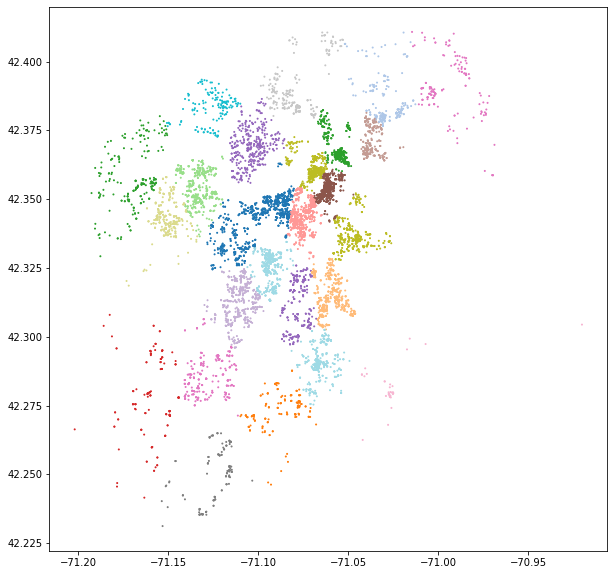

In [51]:
# plotting these clusters 
plt.figure(figsize=(10, 10))
plt.scatter(listings['longitude'], listings['latitude'], c=km.labels_, s=1, cmap="tab20");

In [52]:
# adding new column to dataframe for the clusters
df = listings_dummy.copy()
df['cluster'] = km.labels_

df = pd.get_dummies(df, columns = ['cluster'], drop_first= True)
df.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0,0,0,0,0,0,0,0,0,0
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0,0,0,0,0,0,0,0,1,0


In [54]:
# Try Random Forest
features = [col for col in df._get_numeric_data().columns if col != 'rating_target' and col != 'rating']
print(len(features))

# define X and y
X = df[features]
y = df['rating']

# stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

135


RandomForestRegressor()

In [55]:
# evaluating performance
print(f'Train score: {rf.score(X_train, y_train)}')
print(f'Test score: {rf.score(X_test, y_test)}')

Train score: 0.9408608711830876
Test score: 0.5731419026378838


In [56]:
# trying to cluster around more features
# define X 
X = listings[['latitude','longitude', 'amenities_count', 'host_response_time', 
           'host_response_rate', 'accommodates']]

# went with 26 clusters for the 26 neighborhoods in Boston 
km = KMeans(n_clusters = 26, random_state=42)
km.fit(X)

KMeans(n_clusters=26, random_state=42)

In [57]:
silhouette_score(X, km.labels_)

0.3447537448849499

In [58]:
# adding new column to dataframe for the clusters
df = listings_dummy.copy()
df['cluster'] = km.labels_

df = pd.get_dummies(df, columns = ['cluster'], drop_first= True)
df.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0,0,0,0,0,0,1,0,0,0
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0,0,0,0,0,0,1,0,0,0


In [59]:
# Try Random Forest
features = [col for col in df._get_numeric_data().columns if col != 'rating_target' and col != 'rating']
print(len(features))

# define X and y
X = df[features]
y = df['rating']

# stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

135


RandomForestRegressor()

In [60]:
# evaluating performance
print(f'Train score: {rf.score(X_train, y_train)}')
print(f'Test score: {rf.score(X_test, y_test)}')

Train score: 0.9453037720305036
Test score: 0.5819690878641481


Slight improvement - try to find the optimal k

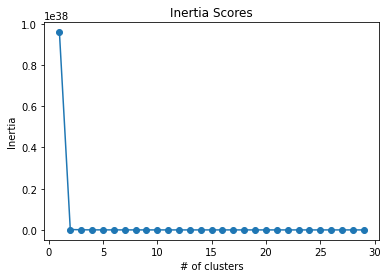

In [61]:
inertia_list = []

for k in range(1,30):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(1,30), inertia_list, marker = 'o')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.title('Inertia Scores');

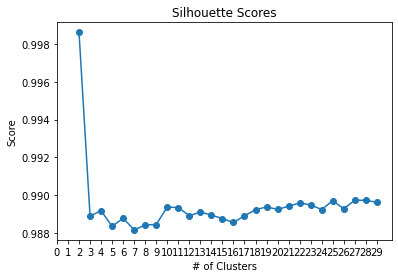

In [62]:
silhouette_list = []

for k in range(2, 30):   # need at least 2 to have separation
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(X)
    silhouette_list.append(silhouette_score(X, kmeans.labels_))
    
plt.plot(range(2, 30), silhouette_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores')
plt.xticks(range(0, 30));

In [65]:
# trying to cluster around more features
# define X 
X = listings[['latitude','longitude', 'amenities_count', 'host_response_time', 
           'host_response_rate', 'accommodates']]

# 2 clusters appears optimal
km = KMeans(n_clusters = 2, random_state=42)
km.fit(X)

KMeans(n_clusters=2, random_state=42)

In [66]:
silhouette_score(X, km.labels_)

0.7488525649323489

In [67]:
# adding new column to dataframe for the clusters
df = listings_dummy.copy()
df['cluster'] = km.labels_

df = pd.get_dummies(df, columns = ['cluster'], drop_first= True)
df.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,property_type_Shared room in condominium (condo),property_type_Shared room in home,property_type_Shared room in rental unit,property_type_Shared room in residential home,property_type_Shared room in townhouse,property_type_Tiny home,room_type_Hotel room,room_type_Private room,room_type_Shared room,cluster_1
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0,0,0,0,0,0,0,0,0,0
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# Try Random Forest
features = [col for col in df._get_numeric_data().columns if col != 'rating_target' and col != 'rating']
print(len(features))

# define X and y
X = df[features]
y = df['rating']

# stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

111


RandomForestRegressor()

In [69]:
# evaluating performance
print(cross_val_score(rf, X_train, y_train, cv = 5).mean())
print(f'Train score: {rf.score(X_train, y_train)}')
print(f'Test score: {rf.score(X_test, y_test)}')

0.5117431957938419
Train score: 0.9407981253982346
Test score: 0.5713238984148363


**DBSCAN**

In [70]:
# define X 
X = listings[['latitude','longitude', 'amenities_count', 'host_response_time', 
           'host_response_rate', 'accommodates']]


dbscan = DBSCAN()
dbscan.fit(X)

print(silhouette_score(X, dbscan.labels_))
print(len(pd.Series(dbscan.labels_).unique()))
pd.Series(dbscan.labels_).unique()

0.40166279196312477
440


array([  0,   1,   2,   3,   4,   5,  -1,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [71]:
# changing epsilon and minimum samples to reduce cluster numbers
dbscan = DBSCAN(eps = 2, min_samples = 5)
dbscan.fit(X)

print(silhouette_score(X, dbscan.labels_))
print(len(pd.Series(dbscan.labels_).unique()))
pd.Series(dbscan.labels_).unique()


-0.2700890326845802
46


array([ 0, -1,  1, 18,  2, 40,  3,  4, 12,  5,  6,  7,  8, 28,  9, 10, 11,
       13, 14, 37, 25, 15, 19, 16, 17, 20, 21, 22, 35, 23, 24, 26, 27, 36,
       30, 29, 38, 31, 32, 33, 34, 42, 44, 39, 41, 43])

In [72]:
# changing epsilon and minimum samples to reduce cluster numbers
dbscan = DBSCAN(eps = 6, min_samples = 5)
dbscan.fit(X)

print(silhouette_score(X, dbscan.labels_))
print(len(pd.Series(dbscan.labels_).unique()))
pd.Series(dbscan.labels_).unique()

0.7233743528106137
4


array([ 0,  1, -1,  2])

In [73]:
cluster_df2 = listings_dummy.copy()
cluster_df2['cluster'] = dbscan.labels_

cluster_df2 = pd.get_dummies(cluster_df2, columns = ['cluster'], drop_first= True)
cluster_df2.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,property_type_Shared room in rental unit,property_type_Shared room in residential home,property_type_Shared room in townhouse,property_type_Tiny home,room_type_Hotel room,room_type_Private room,room_type_Shared room,cluster_0,cluster_1,cluster_2
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0,0,0,0,0,0,0,1,0,0
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0,0,0,0,0,0,0,1,0,0


In [74]:
# Try Random Forest
features = [col for col in cluster_df2._get_numeric_data().columns if col != 'rating_target' and col != 'rating']
print(len(features))

# define X and y
X = cluster_df2[features]
y = cluster_df2['rating']

# stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

113


RandomForestRegressor()

In [75]:
# evaluating performance
print(cross_val_score(rf, X_train, y_train, cv = 5).mean())
print(f'Train score: {rf.score(X_train, y_train)}')
print(f'Test score: {rf.score(X_test, y_test)}')

0.5138282774066646
Train score: 0.9399452461372619
Test score: 0.5649307178565723


DBSCAN is not improving on Kmeans in this case

Slight Improvement from Kmeans clustering - implement to make slightly less overfit model to train on additional city data (and grid search over)

-------
## Best Regression Model

In [56]:
# trying to cluster around more features
# define X 
X = listings[['latitude','longitude', 'amenities_count', 'host_response_time', 
           'host_response_rate', 'accommodates']]

# went with 26 clusters for the 26 neighborhoods in Boston 
km = KMeans(n_clusters = 26, random_state=42)
km.fit(X)

KMeans(n_clusters=26, random_state=42)

In [57]:
silhouette_score(X, km.labels_)

0.3447537448849499

In [58]:
# adding new column to dataframe for the clusters
df = listings_dummy.copy()
df['cluster'] = km.labels_

df = pd.get_dummies(df, columns = ['cluster'], drop_first= True)
df.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,cluster_16,cluster_17,cluster_18,cluster_19,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0,0,0,0,0,0,1,0,0,0
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0,0,0,0,0,0,1,0,0,0


In [59]:
# Try Random Forest
features = [col for col in df._get_numeric_data().columns if col != 'rating_target' and col != 'rating']
print(len(features))

# define X and y
X = df[features]
y = df['rating']

# stratify = y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)

135


RandomForestRegressor()

In [60]:
# evaluating performance
print(f'Train score: {rf.score(X_train, y_train)}')
print(f'Test score: {rf.score(X_test, y_test)}')

Train score: 0.9453037720305036
Test score: 0.5819690878641481


In [91]:
y_preds = rf.predict(X_test)
print(f'Model MSE: {metrics.mean_squared_error(y_test, y_preds)}')

Model MSE: 0.10010706850712678


In [101]:
# establishing the null model accuracy
null_pred = y.mean()
print('null predicted rating is',(round(null_pred, 2)))

# Create the predictions for the "null model"
y_bar = y.mean()
y_bar_2 = y.median()

# The null MSE
null_mse = np.mean((y - y_bar) ** 2)
null_mse_2 = np.mean((y- y_bar_2) ** 2)

if null_mse < null_mse_2:
    print(f'Baseline MSE: {round(null_mse, 2)}')
else: 
    print(f'Baseline MSE: {round(null_mse_2, 2)}')

null predicted rating is 4.68
Baseline MSE: 0.25


------